# When a neural network is traine on both noisy and clean data.
Trained in experiment 19

In [1]:
import gzip
import os
import pickle
import time
import torch
import sys
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import scipy.stats as stats
from collections import defaultdict
from tqdm import tqdm

sys.path.append('./')
sys.path.append('./sw/')

from IVIMNET.hyperparams import hyperparams as hp_example_1
import IVIMNET.simulations as sim
import IVIMNET.deep as deep
import IVIMNET.deep_bayes as deep_bayes
import IVIMNET.fitting_algorithms as fit

# Comptue global variance of input in simulated data

In [2]:
BNN_PATH = f"./sw/models/bnn_e19.pt"
SIGNAL_PATH = f"./sw/data/signals/infer_{{}}SNR_{{}}.pickle.gz"
PLOT_PATH = f"./sw/plots/e10_bnn_cov_vs_snr.png"
SNR = [5, 15, 20, 30, 50]
i = 0

cov_global = []
params = []

In [3]:
signals = {}
for eval_snr in SNR:
    with gzip.open(SIGNAL_PATH.format(eval_snr, i)) as fd:
        signals[eval_snr] = pickle.load(fd)

In [4]:
device = "cuda"

net = torch.load(BNN_PATH, map_location=device)

for eval_snr in tqdm(SNR):
    with gzip.open(SIGNAL_PATH.format(eval_snr, i)) as fd:
        [dwi_image_long, Dt_truth, Fp_truth, Dp_truth] = signals[eval_snr]
        ground_truth = {
            "x": torch.from_numpy(dwi_image_long).float().to(device),
            "dt": torch.from_numpy(Dt_truth).reshape((100*100, 1)),
            "fp": torch.from_numpy(Fp_truth).reshape((100*100, 1)),
            "dp": torch.from_numpy(Dp_truth).reshape((100*100, 1))
        }

    x, dt, fp, dp, s0 = net(ground_truth["x"])

    x_mu = (torch.mean(x, dim=0))
    x_sigma = (torch.std(x, dim=0))

    cov_global.append((x_sigma/x_mu).detach().cpu())
    params.append({
            "x": x.detach().cpu().numpy().reshape((256, 100, 100, 11)),
            "dt": dt.detach().cpu().numpy().reshape((256, 100, 100, 1)),
            "fp": fp.detach().cpu().numpy().reshape((256, 100, 100, 1)),
            "dp": dp.detach().cpu().numpy().reshape((256, 100, 100, 1)),
            "eval_snr": eval_snr
    })

    del x
    del dt
    del fp
    del dp
    del s0
    del x_sigma
    del ground_truth["x"]
del net

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.08it/s]


In [5]:
torch.cuda.empty_cache()

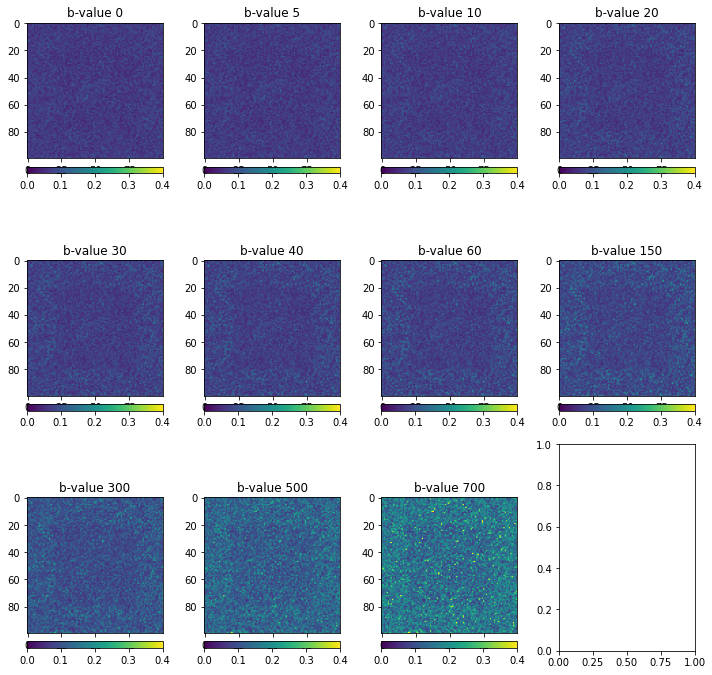

In [6]:
bvalues = np.array([0, 5, 10, 20, 30, 40, 60, 150, 300, 500, 700])
fig, axs = plt.subplots(3,4, figsize=(10, 10))
fig.delaxes(ax=axs[2,3])
for i in range(11):
    ax = axs[i//4, i%4]
    p = ax.imshow(cov_global[0][:,i].reshape(100,100), clim=(0, 0.4))
    ax.set_title(f"b-value {bvalues[i]}")
    fig.colorbar(p, ax=ax, fraction=0.046, pad=0.04, orientation="horizontal")
fig.tight_layout()
plt.show()

No handles with labels found to put in legend.


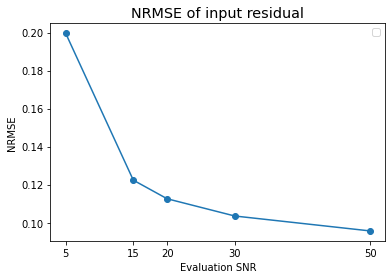

In [7]:
data = []
for eval_snr_idx in range(5):
    mean = np.mean(params[eval_snr_idx]["x"], axis=0)
    assert params[eval_snr_idx]["eval_snr"] == SNR[eval_snr_idx]
    rmse = np.sqrt(np.square(mean - signals[eval_snr][0].reshape(100,100,11)))
    nrmse = rmse / np.mean(signals[eval_snr][0], axis=0)
    data.append(float(np.mean(nrmse)))

plt.plot(SNR, data, marker='o')

plt.legend(loc=0)
plt.title(r"NRMSE of input residual", fontsize="x-large")
plt.xticks(SNR)
# plt.tight_layout()
plt.xlabel("Evaluation SNR")
plt.ylabel("NRMSE")
# plt.yscale("log")
# plt.savefig()
plt.show()

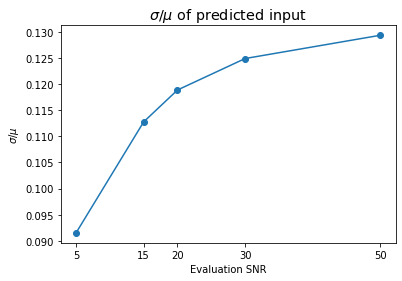

In [8]:

data = []
for eval_snr_idx in range(5):
    cov = cov_global[eval_snr_idx]
    assert params[eval_snr_idx]["eval_snr"] == SNR[eval_snr_idx]
    data.append(float(torch.mean(cov)))

plt.plot(SNR, data, marker='o')

# plt.legend(loc=0)
plt.title(r"$\sigma / \mu$ of predicted input", fontsize="x-large")
plt.xticks(SNR)
# plt.tight_layout()
plt.xlabel("Evaluation SNR")
plt.ylabel(f"$\sigma / \mu$")
# plt.yscale("log")
# plt.savefig()
plt.show()

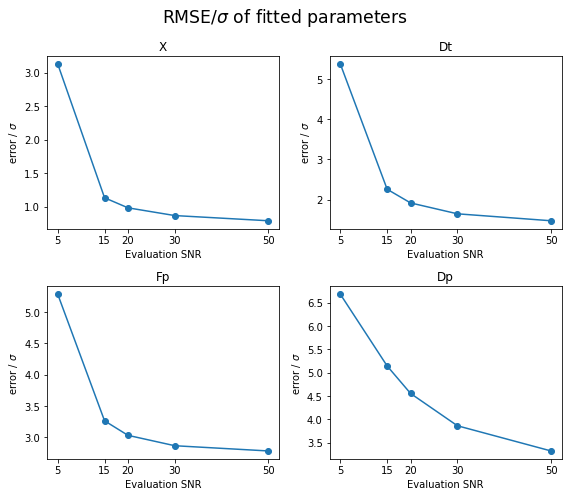

In [12]:
fig, ax = plt.subplots(2,2, figsize=(8,7))

def compute_cov(param_name, param_idx):
    data = []
    for eval_snr_idx in range(5):
        true_value = signals[SNR[eval_snr_idx]][param_idx].reshape(100,100,-1)
        predicted = params[eval_snr_idx][param_name]
        assert params[eval_snr_idx]["eval_snr"] == SNR[eval_snr_idx]
        
        std = np.std(predicted, axis=0)
        mean = np.mean(predicted, axis=0)
        err = np.sqrt(np.square(mean - true_value))
        how_many_stdevs = err / std
        
        data.append(float(np.mean(how_many_stdevs)))
    return data

for i,param in enumerate("X Dt Fp Dp".split()):
    ax[i//2, i%2].plot(SNR, compute_cov(param.lower(), i), marker="o")
    i = (i//2, i%2)
    ax[i].set_title(param)
    ax[i].set_xlabel("Evaluation SNR")
    ax[i].set_ylabel(f"error / $\sigma$")
    ax[i].set_xticks(SNR)
    # ax[i].legend()

fig.suptitle(f"RMSE/$\sigma$ of fitted parameters", fontsize="xx-large")
fig.tight_layout()
plt.show()

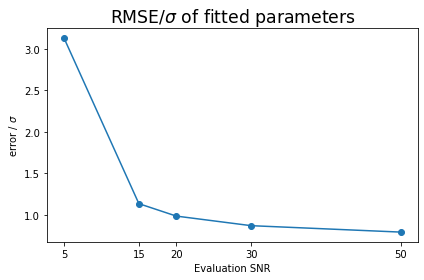

In [10]:
plt.plot(SNR, compute_cov("x", 0), marker="o")

plt.xlabel("Evaluation SNR")
plt.ylabel(f"error / $\sigma$")
plt.xticks(SNR)

# plt.legend()
plt.title(f"RMSE/$\sigma$ of fitted parameters", fontsize="xx-large")

plt.tight_layout()
plt.show()

(100, 100) (100, 100, 1)


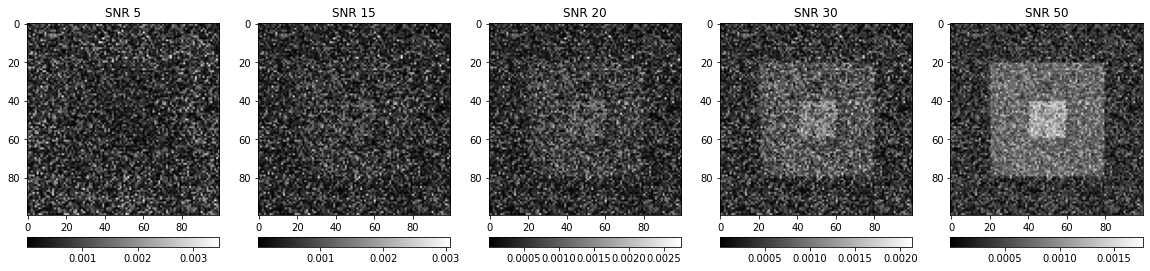

In [11]:
ig, axs = plt.subplots(1,5, figsize=(20, 20))
i=2
print(signals[SNR[i]][1].shape, np.mean(params[i]["dt"], axis=0).shape)
for i in range(5):
    img = np.abs(np.mean(params[i]["dt"], axis=0) - signals[SNR[i]][1].reshape(100,100,1))
    p = axs[i].imshow(img, cmap="gray")
    axs[i].set_title(f"SNR {SNR[i]}")
    fig.colorbar(p, ax=axs[i], fraction=0.046, pad=0.02, orientation="horizontal")

# fig.suptitle(f"Parameter maps of Dt (training SNR=5)")
# fig.tight_layout()
plt.show()

## Let's examine one pixel

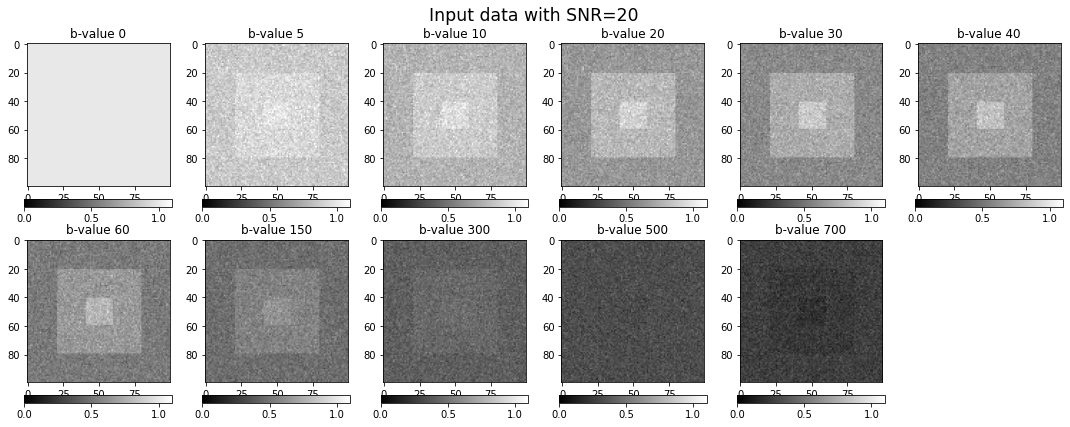

In [ ]:
# Plot bvalues
eval_snr_idx = 2
X, dt, fp, dp = signals[SNR[eval_snr_idx]]

fig, ax = plt.subplots(2, 6, figsize=(15, 6))
for i in range(11):
    p = ax[i//6, i%6].imshow(X[:, i].reshape(100,100), cmap="gray", clim=(0, 1.1))
    fig.colorbar(p, ax=ax[i//6, i%6], fraction=0.046, pad=0.08, orientation="horizontal")
    ax[i//6, i%6].set_title(f"b-value {bvalues[i]}")

fig.delaxes(ax[1, 5])
fig.suptitle(f"Input data with SNR={SNR[eval_snr_idx]}", fontsize="xx-large")
fig.tight_layout()
plt.show()

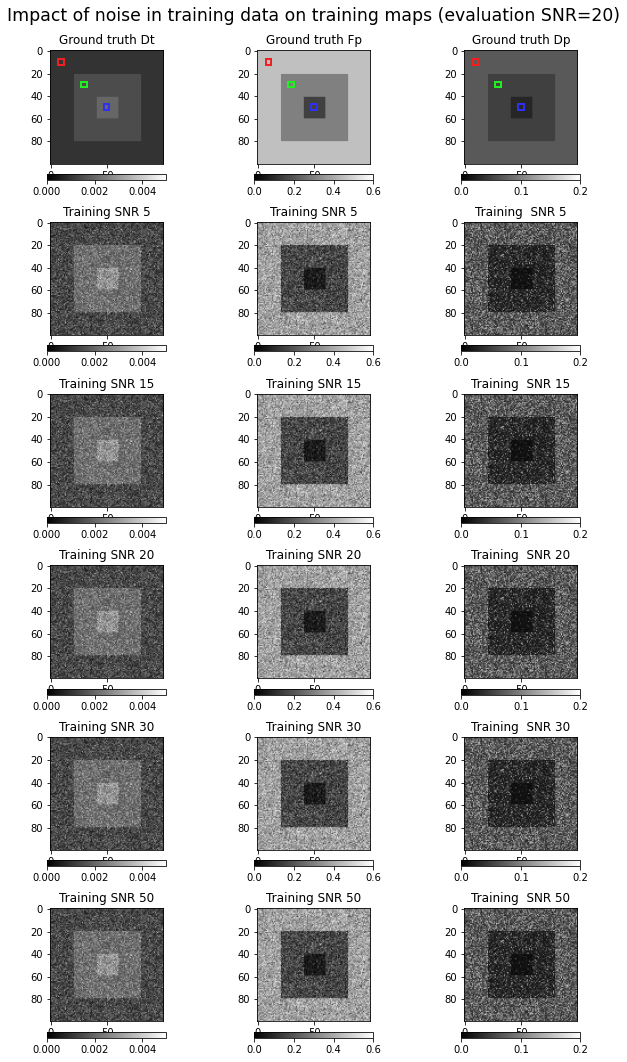

In [53]:
mid = 10
extent = 5
s = slice(mid-(extent//2) , mid+(extent+1)//2)

rec1 = patches.Rectangle(( 7,  7), extent, extent, linewidth=2, edgecolor='r', facecolor='none')
rec2 = patches.Rectangle((27, 27), extent, extent, linewidth=2, edgecolor='g', facecolor='none')
rec3 = patches.Rectangle((47, 47), extent, extent, linewidth=2, edgecolor='b', facecolor='none')

fig, ax = plt.subplots(6,3, figsize=(9, 15))
p=ax[0,0].imshow(dt.reshape(100,100), cmap="gray", clim=(0, 0.005))
ax[0,0].set_title("Ground truth Dt")
fig.colorbar(p, ax=ax[0,0], fraction=0.046, pad=0.08, orientation="horizontal")

p = ax[0,1].imshow(fp.reshape(100,100), cmap="gray", clim=(0, 0.6))
ax[0,1].set_title("Ground truth Fp")
fig.colorbar(p, ax=ax[0,1], fraction=0.046, pad=0.08, orientation="horizontal")

p = ax[0,2].imshow(dp.reshape(100,100), cmap="gray", clim=(0, 0.2))
ax[0,2].set_title("Ground truth Dp")
fig.colorbar(p, ax=ax[0,2], fraction=0.046, pad=0.08, orientation="horizontal")

for i in range(3):
    ax[0,i].add_patch(patches.Rectangle(( 7,  7), extent, extent, linewidth=2, edgecolor='#f02020', facecolor='none'))
    ax[0,i].add_patch(patches.Rectangle((27, 27), extent, extent, linewidth=2, edgecolor='#20f020', facecolor='none'))
    ax[0,i].add_patch(patches.Rectangle((47, 47), extent, extent, linewidth=2, edgecolor='#3030f0', facecolor='none'))

# Estimated mean
for i in range(1, 6):
    p=ax[i,0].imshow(np.mean(params[eval_snr_idx]["dt"], axis=0).reshape(100,100), cmap="gray", clim=(0, 0.005))
    ax[i,0].set_title(f"Training SNR {SNR[i-1]}")
    fig.colorbar(p, ax=ax[i,0], fraction=0.046, pad=0.08, orientation="horizontal")

    p = ax[i,1].imshow(np.mean(params[eval_snr_idx]["fp"], axis=0).reshape(100,100), cmap="gray", clim=(0, 0.6))
    ax[i,1].set_title(f"Training SNR {SNR[i-1]}")
    fig.colorbar(p, ax=ax[i,1], fraction=0.046, pad=0.08, orientation="horizontal")

    p = ax[i,2].imshow(np.mean(params[eval_snr_idx]["dp"], axis=0).reshape(100,100), cmap="gray", clim=(0, 0.2))
    ax[i,2].set_title(f"Training  SNR {SNR[i-1]}")
    fig.colorbar(p, ax=ax[i,2], fraction=0.046, pad=0.08, orientation="horizontal")


fig.tight_layout()
fig.subplots_adjust(top=0.94)
fig.suptitle(f"Impact of noise in training data on training maps (evaluation SNR={SNR[eval_snr_idx]})", fontsize="xx-large")

plt.show()

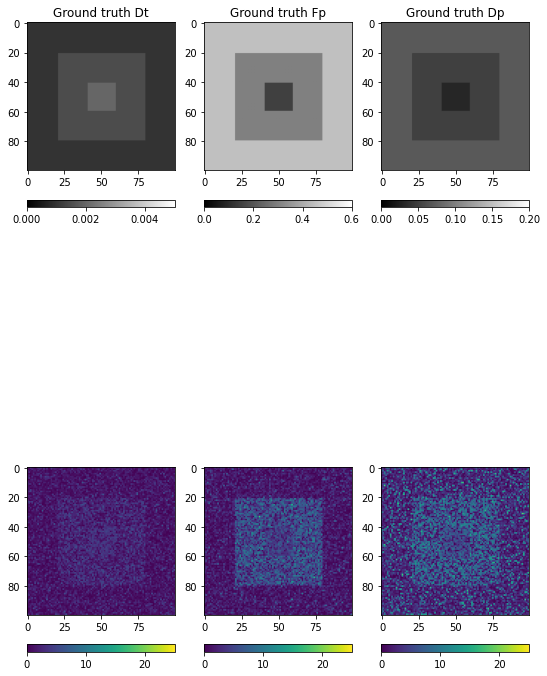

In [54]:
mid = 10
extent = 5
s = slice(mid-(extent//2) , mid+(extent+1)//2)

fig, ax = plt.subplots(6,3, figsize=(9, 15))
p=ax[0,0].imshow(dt.reshape(100,100), cmap="gray", clim=(0, 0.005))
ax[0,0].set_title("Ground truth Dt")
fig.colorbar(p, ax=ax[0,0], fraction=0.046, pad=0.08, orientation="horizontal")

p = ax[0,1].imshow(fp.reshape(100,100), cmap="gray", clim=(0, 0.6))
ax[0,1].set_title("Ground truth Fp")
fig.colorbar(p, ax=ax[0,1], fraction=0.046, pad=0.08, orientation="horizontal")

p = ax[0,2].imshow(dp.reshape(100,100), cmap="gray", clim=(0, 0.2))
ax[0,2].set_title("Ground truth Dp")
fig.colorbar(p, ax=ax[0,2], fraction=0.046, pad=0.08, orientation="horizontal")

# Estimated mean
for i in range(1, 6):
    pname, pidx = "dt", 1
    dat = np.abs(np.mean(params[eval_snr_idx][pname], axis=0) - signals[eval_snr][pidx].reshape(100,100,1)) / np.std(params[eval_snr_idx]["dt"], axis=0)
    p=ax[i,0].imshow(dat, clim=(0, 25))
    ax[i,0].set_title(f"Training SNR {SNR[i-1]}")
    fig.colorbar(p, ax=ax[i,0], fraction=0.046, pad=0.08, orientation="horizontal")

    pname, pidx = "fp", 2
    dat = np.abs(np.mean(params[eval_snr_idx][pname], axis=0) - signals[eval_snr][pidx].reshape(100,100,1)) / np.std(params[eval_snr_idx][pname], axis=0)
    p = ax[i,1].imshow(dat, clim=(0, 25))
    ax[i,1].set_title(f"Training SNR {SNR[i-1]}")
    fig.colorbar(p, ax=ax[i,1], fraction=0.046, pad=0.08, orientation="horizontal")

    pname, pidx = "dp", 3
    dat = np.abs(np.mean(params[eval_snr_idx][pname], axis=0) - signals[eval_snr][pidx].reshape(100,100,1)) / np.std(params[eval_snr_idx][pname], axis=0)
    p = ax[i,2].imshow(dat, clim=(0, 25))
    ax[i,2].set_title(f"Training  SNR {SNR[i-1]}")
    fig.colorbar(p, ax=ax[i,2], fraction=0.046, pad=0.08, orientation="horizontal")


fig.tight_layout()
fig.subplots_adjust(top=0.94)
fig.suptitle(fr"error / $\sigma$ (evaluation SNR={SNR[eval_snr_idx]})", fontsize="xx-large")

plt.show()

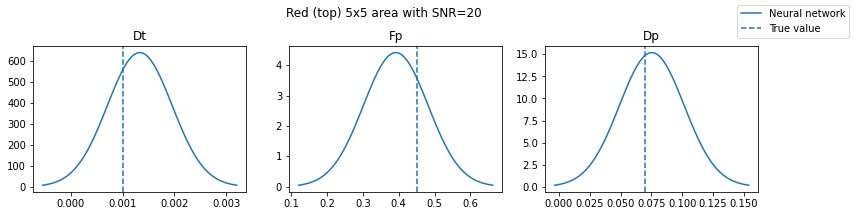

In [55]:
mid = 10
fig, ax = plt.subplots(1,3, figsize=(13, 3))
fig.suptitle(f"Red (top) 5x5 area with SNR={SNR[eval_snr_idx]}")

ds = params[eval_snr_idx]["dt"][:, s, s, 0]
mu = np.mean(ds)
sigma = np.mean(np.std(ds))
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
ax[0].plot(x, stats.norm.pdf(x, mu, sigma), label=f"Neural network")
ax[0].axvline(x=np.mean(dt[s, s]), label="True value", ls="--")
ax[0].set_title("Dt")
# ax[0].legend()

ds = params[eval_snr_idx]["fp"][:, s, s, 0]
mu = np.mean(ds)
sigma = np.mean(np.std(ds))
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
ax[1].plot(x, stats.norm.pdf(x, mu, sigma))#, label=f"Training SNR {SNR[i]}")
ax[1].axvline(x=np.mean(fp[s, s]), ls="--")#, label="True Fp")
ax[1].set_title("Fp")
# ax[1].legend()

ds = params[eval_snr_idx]["dp"][:, s, s, 0]
mu = np.mean(ds)
sigma = np.mean(np.std(ds))
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
ax[2].plot(x, stats.norm.pdf(x, mu, sigma))#, label=f"Training SNR {SNR[i]}")
ax[2].axvline(x=np.mean(dp[s, s]), ls="--")#, label="True Dp")
ax[2].set_title("Dp")
fig.legend()
fig.subplots_adjust(top=0.8)


plt.show()


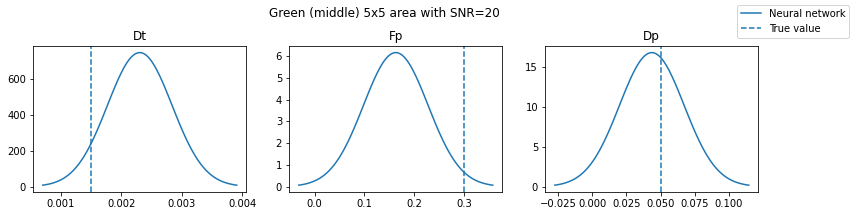

In [56]:
mid = 30
s = slice(mid-(extent//2) , mid+(extent+1)//2)

fig, ax = plt.subplots(1,3, figsize=(13, 3))
fig.suptitle(f"Green (middle) 5x5 area with SNR={SNR[eval_snr_idx]}")

ds = params[eval_snr_idx]["dt"][:, s, s, 0]
mu = np.mean(ds)
sigma = np.mean(np.std(ds))
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
ax[0].plot(x, stats.norm.pdf(x, mu, sigma), label=f"Neural network")
ax[0].axvline(x=np.mean(dt[s, s]), label="True value", ls="--")
ax[0].set_title("Dt")
# ax[0].legend()

ds = params[eval_snr_idx]["fp"][:, s, s, 0]
mu = np.mean(ds)
sigma = np.mean(np.std(ds))
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
ax[1].plot(x, stats.norm.pdf(x, mu, sigma))#, label=f"Training SNR {SNR[i]}")
ax[1].axvline(x=np.mean(fp[s, s]), ls="--")#, label="True Fp")
ax[1].set_title("Fp")
# ax[1].legend()

ds = params[eval_snr_idx]["dp"][:, s, s, 0]
mu = np.mean(ds)
sigma = np.mean(np.std(ds))
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
ax[2].plot(x, stats.norm.pdf(x, mu, sigma))#, label=f"Training SNR {SNR[i]}")
ax[2].axvline(x=np.mean(dp[s, s]), ls="--")#, label="True Dp")
ax[2].set_title("Dp")
fig.legend()
fig.subplots_adjust(top=0.8)


plt.show()


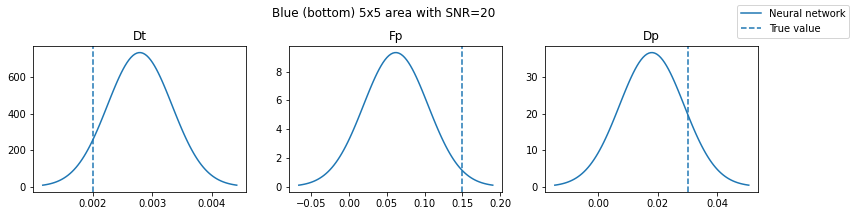

In [57]:
_, dt, fp, dp = signals[SNR[eval_snr_idx]]
mid = 50
s = slice(mid-(extent//2) , mid+(extent+1)//2)

fig, ax = plt.subplots(1,3, figsize=(13, 3))
fig.suptitle(f"Blue (bottom) 5x5 area with SNR={SNR[eval_snr_idx]}")

ds = params[eval_snr_idx]["dt"][:, s, s, 0]
mu = np.mean(ds)
sigma = np.mean(np.std(ds))
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
ax[0].plot(x, stats.norm.pdf(x, mu, sigma), label=f"Neural network")
ax[0].axvline(x=np.mean(dt[s, s]), label="True value", ls="--")
ax[0].set_title("Dt")
# ax[0].legend()


ds = params[eval_snr_idx]["fp"][:, s, s, 0]
mu = np.mean(ds)
sigma = np.mean(np.std(ds))
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
ax[1].plot(x, stats.norm.pdf(x, mu, sigma))#, label=f"Training SNR {SNR[i]}")
ax[1].axvline(x=np.mean(fp[s, s]), ls="--")#, label="True Fp")
ax[1].set_title("Fp")
# ax[1].legend()


ds = params[eval_snr_idx]["dp"][:, s, s, 0]
mu = np.mean(ds)
sigma = np.mean(np.std(ds))
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
ax[2].plot(x, stats.norm.pdf(x, mu, sigma))#, label=f"Training SNR {SNR[i]}")
ax[2].axvline(x=np.mean(dp[s, s]), ls="--")#, label="True Dp")
ax[2].set_title("Dp")
fig.legend()
fig.subplots_adjust(top=0.8)


plt.show()
